In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import folium
import numpy as np
from utils import *
from sklearn.feature_extraction.text import CountVectorizer
from vincent import (Visualization, Scale, DataRef, Data, PropertySet,
                     Axis, ValueRef, MarkRef, MarkProperties, Mark)
from PIL import Image
from os import path
import os
import random
from wordcloud import WordCloud, ImageColorGenerator
from scipy.ndimage import gaussian_gradient_magnitude
import json

# Disable FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

%matplotlib inline

In [17]:
# Draw a plot on the relevant axis

def Display_Plot(df:pd.DataFrame, plot_type, axis:pd.DataFrame.axes, title, color):
    axis.bar(x= df["Year"], height = df["Total Reviews"], color=color)
    for index, col in enumerate(df["Total Reviews"]):
        txt_len = len(str(col))
        axis.annotate(str(col), xy=(index,col), xytext=(-txt_len,txt_len*1.2), textcoords='offset points', rotation=-45)
            
    axis.set_title(title[::-1])
    axis.set_ymargin(0.15)
    axis.set_xticklabels(axis.get_xticklabels(), rotation=90)

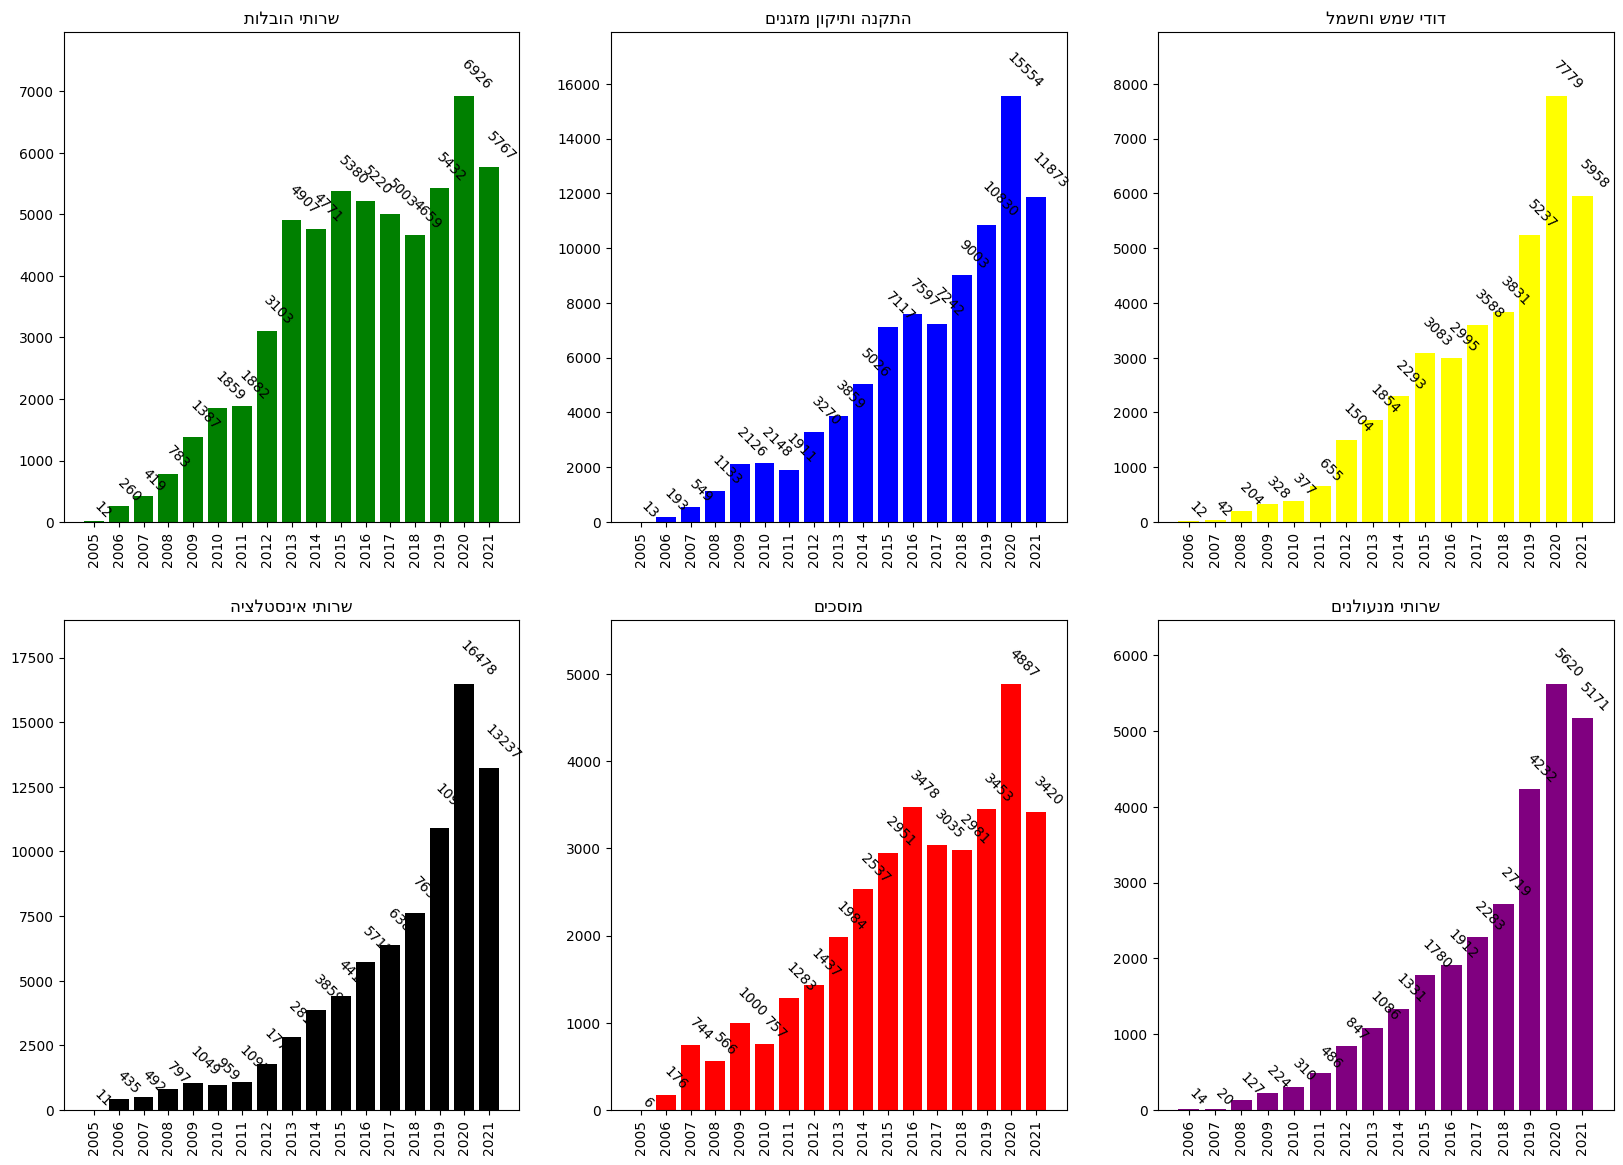

In [18]:
# Displaying all the reviews per year for each category

fig, axes = plt.subplots(2,3, figsize=(20,14))
colors = [
    ['green', 'blue','yellow'],
    ['black', 'red', 'purple']
]
categories_csv = Get_All_CSV_Names()
row = 0
index = 0

for cat in categories_csv:
    df = pd.read_csv(f"data/ML/summery_{cat}.csv")
    df["Year"] = df["Year"].astype("string")

    Display_Plot(df, "bar", axes[row, index], cat, colors[row][index])
    
    if index == 2:
        row = 1
        index = 0
    else:
        index+=1

In [19]:
# Display line plot with seaborn
def Display_Graph_Seaborn(df:pd.DataFrame, x_axis, y_axis, hue_title, plot_type, axis:pd.DataFrame.axes, main_title, hue_order):
    if plot_type == 'line':
        sns.lineplot(ax=axis, x=x_axis, y=y_axis, hue=hue_title, hue_order=hue_order, data=df, marker="o", markersize=5)
        axis.set_title(main_title)
        axis.tick_params(labelrotation=90)

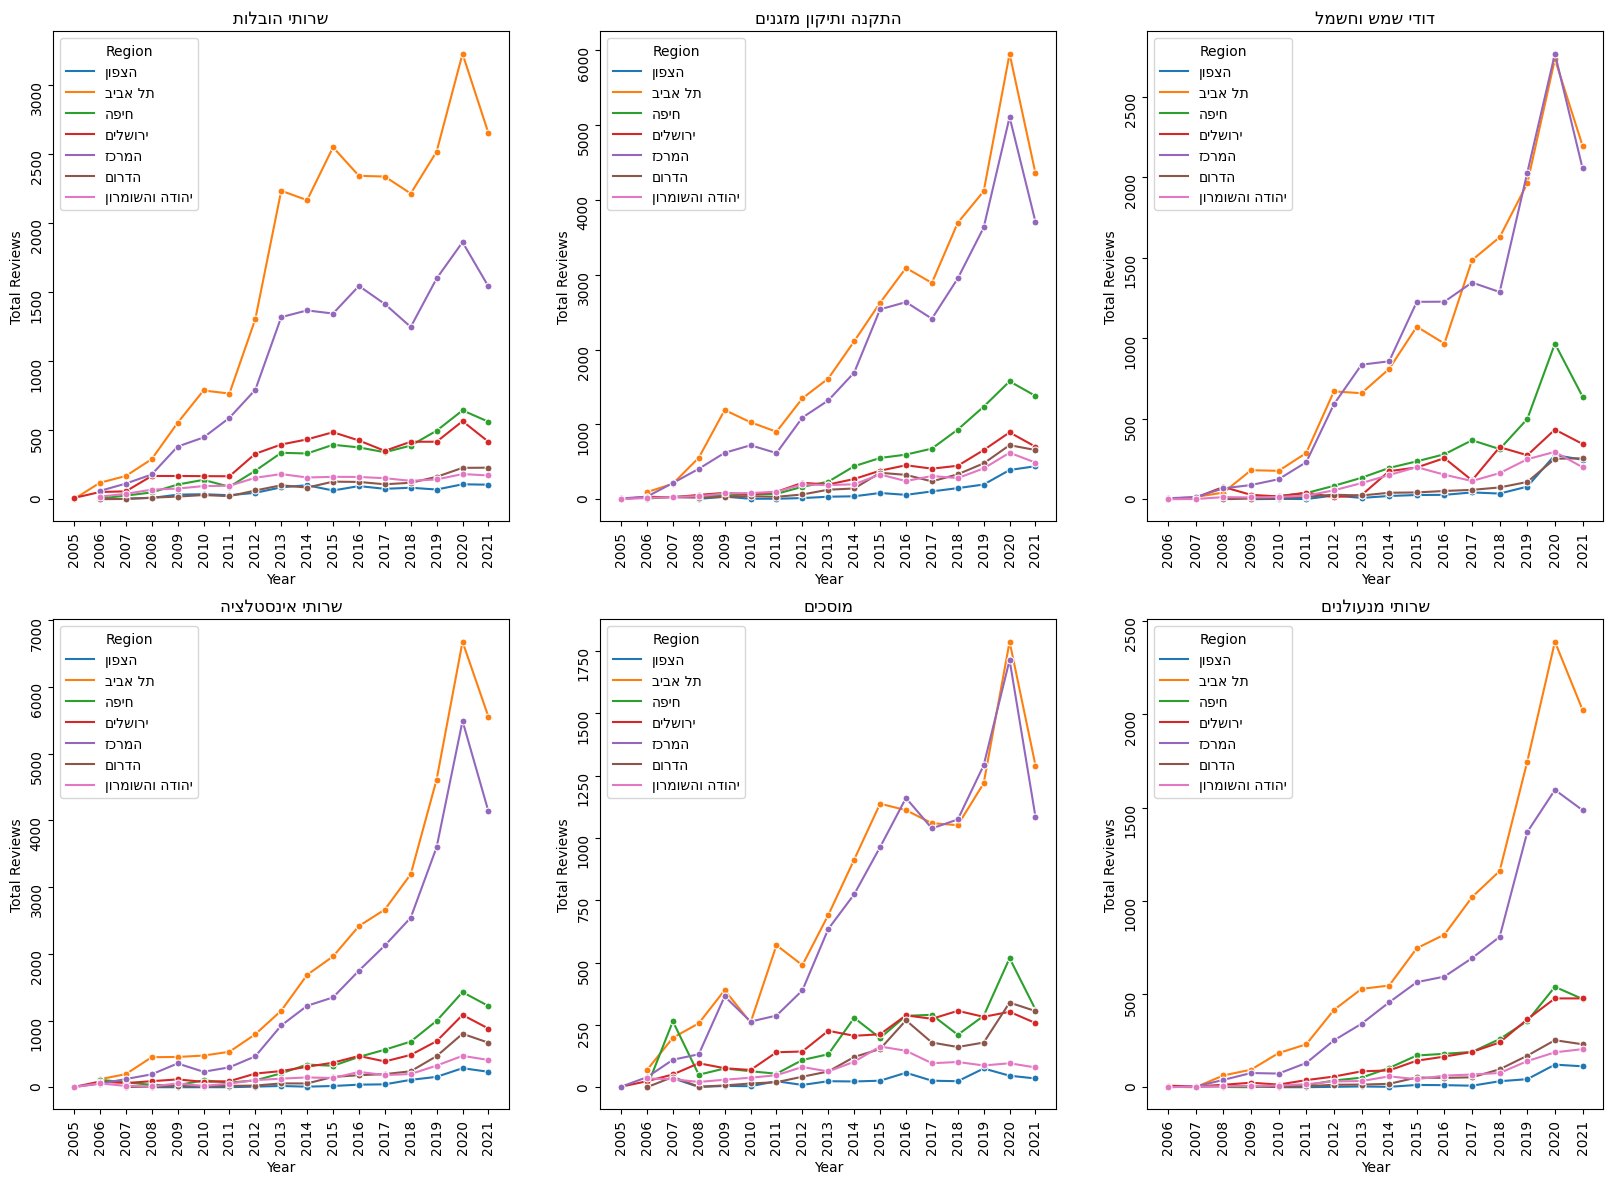

In [20]:
filenames = Get_All_CSV_Names()

fig, axes = plt.subplots(2, 3, figsize=(20, 14))

regions = ['ןופצה', 'ביבא לת', 'הפיח', 'םילשורי', 'זכרמה', 'םורדה', 'ןורמושהו הדוהי'] # region names in hebrew in reverse

row = 0
index = 0

for csv in filenames:
    df = pd.read_csv(f"data/{csv}.csv")
    df.drop(df[df.Region == 'חסוי'].index, inplace=True)
    
    df["Year"] = df["Year"].astype(str)
    df["Region"] = df["Region"].apply(lambda x: x[::-1])
    
    grouped = df.groupby([df['Year'], 'Region'])

    reviews_per_year_and_region = grouped['Region'].count().reset_index(name='Total Reviews')
    
    Display_Graph_Seaborn(reviews_per_year_and_region, "Year", "Total Reviews", "Region", 'line', axes[row,index], csv[::-1], regions)

    if index == 2:
        row = 1
        index = 0
    else:
        index+=1

In [21]:
# credit 1: https://amueller.github.io/word_cloud/auto_examples/parrot.html#sphx-glr-auto-examples-parrot-py
# credit 2: https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html#sphx-glr-auto-examples-a-new-hope-py

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

def Words_On_Picture(text, stopwords, font_path, axis:pd.DataFrame.axes, is_greyscale, title): 
    d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
    
    # load image. This has been modified in gimp to be brighter and have more saturation.
    img_color = np.array(Image.open(os.path.join(d, f'pictures/Handyman.png')))
    # subsample by factor of 3. Very lossy but for a wordcloud we don't really care.
    # img_color = img_color[::3, ::3]

    # create mask  white is "masked out"
    img_mask = img_color.copy()
    img_mask[img_mask.sum(axis=2) == 0] = 255

    # some finesse: we enforce boundaries between colors so they get less washed out.
    # For that we do some edge detection in the image
    edges = np.mean([gaussian_gradient_magnitude(img_color[:, :, i] / 255., 2) for i in range(3)], axis=0)
    img_mask[edges > .08] = 255

    # create wordcloud. A bit sluggish, you can subsample more strongly for quicker rendering
    # relative_scaling=0 means the frequencies in the data are reflected less
    # acurately but it makes a better picture
    wc = WordCloud(max_words=2000, mask=img_mask, font_path = font_path, stopwords = stopwords, max_font_size=40, random_state=42, relative_scaling=0)

    # generate word cloud
    wc.generate(text)

    # create coloring from image
    colors = ImageColorGenerator(img_color)
    if is_greyscale == 0:
        wc.recolor(color_func=colors)
    elif is_greyscale == 1:
        wc.recolor(color_func=grey_color_func, random_state=3)

    axis.imshow(wc, interpolation="bilinear")
    axis.grid(False)
    axis.set_title(title)

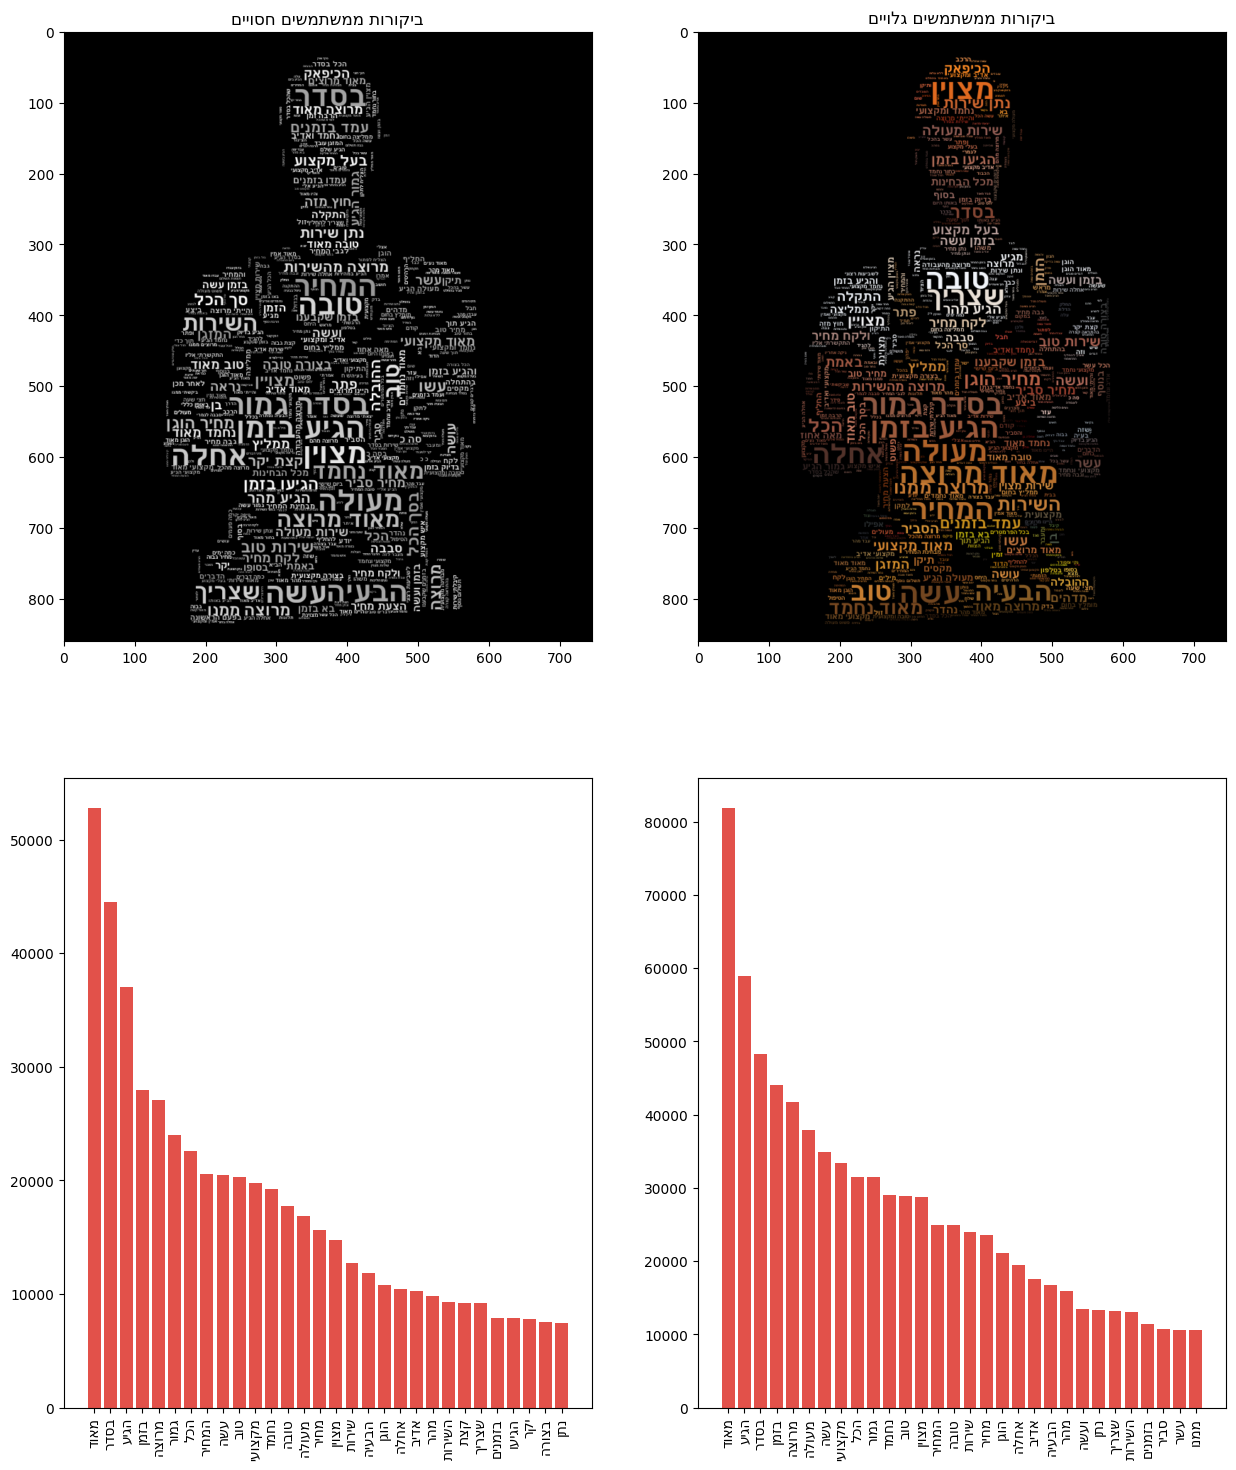

In [27]:
# Check difference between 'חסוי' and visible reviews
# Showing Wordclould and graph for each category to show most frequent words used

#Font path for each PC
font_path=r'C:\Users\Omer\AppData\Local\Microsoft\Windows\Fonts\FreeSansBold.ttf'
# font_path=r'C:\Users\Daniel Ventura\AppData\Local\Microsoft\Windows\Fonts\FreeSansBold.ttf'

stop_words = ['לדעתי', 'העבודה', 'עבודה', 'שהיה', 'שזהו', 'שהם', 'והכל', 'יום', 'הכי', 'והיה', 'והוא', 'שהוא', 'לעשות','אמר', 'ולא', 'ואני', 'דבר','הייתי', 'הייתה', 'צריך', 'וגם', 'אדם', 'היו', 'ממש','שלי','לי','הם','אני', 'את', 'אתה', 'אנחנו', 'אתן', 'אתם', 'הם', 'הן', 'היא', 'הוא', 'שלי', 'שלו', 'שלך', 'שלה', 'שלנו', 'שלכם', 'שלכן', 'שלהם', 'שלהן', 'לי', 'לו', 'לה', 'לנו', 'לכם', 'לכן', 'להם', 'להן', 'אותה', 'אותו', 'זה', 'זאת', 'אלה', 'אלו', 'תחת', 'מתחת', 'מעל', 'בין', 'עם', 'עד', 'נגר', 'על', 'אל', 'מול', 'של', 'אצל', 'כמו', 'אחר', 'אותו', 'בלי', 'לפני', 'אחרי', 'מאחורי', 'עלי', 'עליו', 'עליה', 'עליך', 'עלינו', 'עליכם', 'עליכן', '10','עליהם', 'עליהן', 'כל', 'כולם', 'כולן', 'כך', 'ככה', 'כזה', 'זה', 'זות', 'אותי', 'אותה', 'אותם', 'אותך', 'אותו', 'אותן', 'אותנו', 'ואת', 'את', 'אתכם', 'אתכן', 'איתי', 'איתו', 'איתך', 'איתה', 'איתם', 'איתן', 'איתנו', 'איתכם', 'איתכן', 'יהיה', 'תהיה', 'היתי', 'היתה', 'היה', 'להיות', 'עצמי', 'עצמו', 'עצמה', 'עצמם', 'עצמן', 'עצמנו', 'עצמהם', 'עצמהן', 'מי', 'מה', 'איפה', 'היכן', 'במקום שבו', 'אם', 'לאן', 'למקום שבו', 'מקום בו', 'איזה', 'מהיכן', 'איך', 'כיצד', 'באיזו מידה', 'מתי', 'בשעה ש', 'כאשר', 'כש', 'למרות', 'לפני', 'אחרי', 'מאיזו סיבה', 'הסיבה שבגללה', 'למה', 'מדוע', 'לאיזו תכלית', 'כי', 'יש', 'אין', 'אך', 'מנין', 'מאין', 'מאיפה', 'יכל', 'יכלה', 'יכלו', 'יכול', 'יכולה', 'יכולים', 'יכולות', 'יוכלו', 'יוכל', 'מסוגל', 'לא', 'רק', 'אולי', 'אין', 'לאו', 'אי', 'כלל', 'נגד', 'אם', 'עם', 'אל', 'אלה', 'אלו', 'אף', 'על', 'מעל', 'מתחת', 'מצד', 'בשביל', 'לבין', 'באמצע', 'בתוך', 'דרך', 'מבעד', 'באמצעות', 'למעלה', 'למטה', 'מחוץ', 'מן', 'לעבר', 'מכאן', 'כאן', 'הנה', 'הרי', 'פה', 'שם', 'אך', 'ברם', 'שוב', 'אבל', 'מבלי', 'בלי', 'מלבד', 'רק', 'בגלל', 'מכיוון', 'עד', 'אשר', 'ואילו', 'למרות', 'אס', 'כמו', 'כפי', 'אז', 'אחרי', 'כן', 'לכן', 'לפיכך', 'מאד', 'עז', 'מעט', 'מעטים', 'במידה', 'שוב', 'יותר', 'מדי', 'גם', 'כן', 'נו', 'אחר', 'אחרת', 'אחרים', 'אחרות', 'אשר', 'או']
fig, axes = plt.subplots(2, 2, figsize=(15, 18))

txt_hidden = ""
txt_not_hidden = ""

df_main = pd.DataFrame()
filenames = Get_All_CSV_Names()

# concatenating "לא" variances to the next word: so we can catch these combinations: "לא הגיעה, לא טוב, etc"
for csv in filenames:
    df = pd.read_csv(f"data/{csv}.csv")
    df.Review = df.Review.str.replace(" שלא ", " לא ")
    df.Review = df.Review.str.replace(" ולא ", " לא ")
    df.Review = df.Review.str.replace(" לא ", " #@#@") # "#@#@" is used as a placeholder to bypass wordcloud automatic parsing

    txt_hidden += df.loc[df["Is Hidden"] == 1].Review.str.cat(sep=' ')
    txt_not_hidden += df.loc[df["Is Hidden"] == 0].Review.str.cat(sep=' ')

txt_hidden = txt_hidden[::-1]
txt_not_hidden = txt_not_hidden[::-1]

for index, word in enumerate(stop_words):
    stop_words[index] = word[::-1]

txt_list = [txt_hidden, txt_not_hidden]
title = ["ביקורות ממשתמשים חסויים", "ביקורות ממשתמשים גלויים"]
index = 0

for txt in txt_list:
    vectorizer=CountVectorizer(stop_words=stop_words)
    freq_vec=vectorizer.fit_transform([txt]).toarray() 
    freqDist=dict(zip(vectorizer.get_feature_names_out(),freq_vec[0])) 
    freqDist=dict(sorted(freqDist.items(), key=lambda item: item[1],reverse=True))

    freqDist = {key.replace('@#@#', ' אל'): value for key, value in freqDist.items()} # restore placeholder

    # 1/0 in the call to "Words_On_Picture" indicates "is_greyscale"
    if index == 0: 
        Words_On_Picture(txt, stop_words, font_path, axes[0, index], 1, title[index][::-1])
    elif index == 1:
        Words_On_Picture(txt, stop_words, font_path, axes[0, index], 0, title[index][::-1])
    
    topK=30
    axes[1,index].bar(list(freqDist.keys())[:topK], list(freqDist.values())[:topK])
    axes[1,index].set_xticklabels(axes[1,index].get_xticklabels(), rotation=90)

    index += 1

array([<AxesSubplot: ylabel='Is Hidden'>], dtype=object)

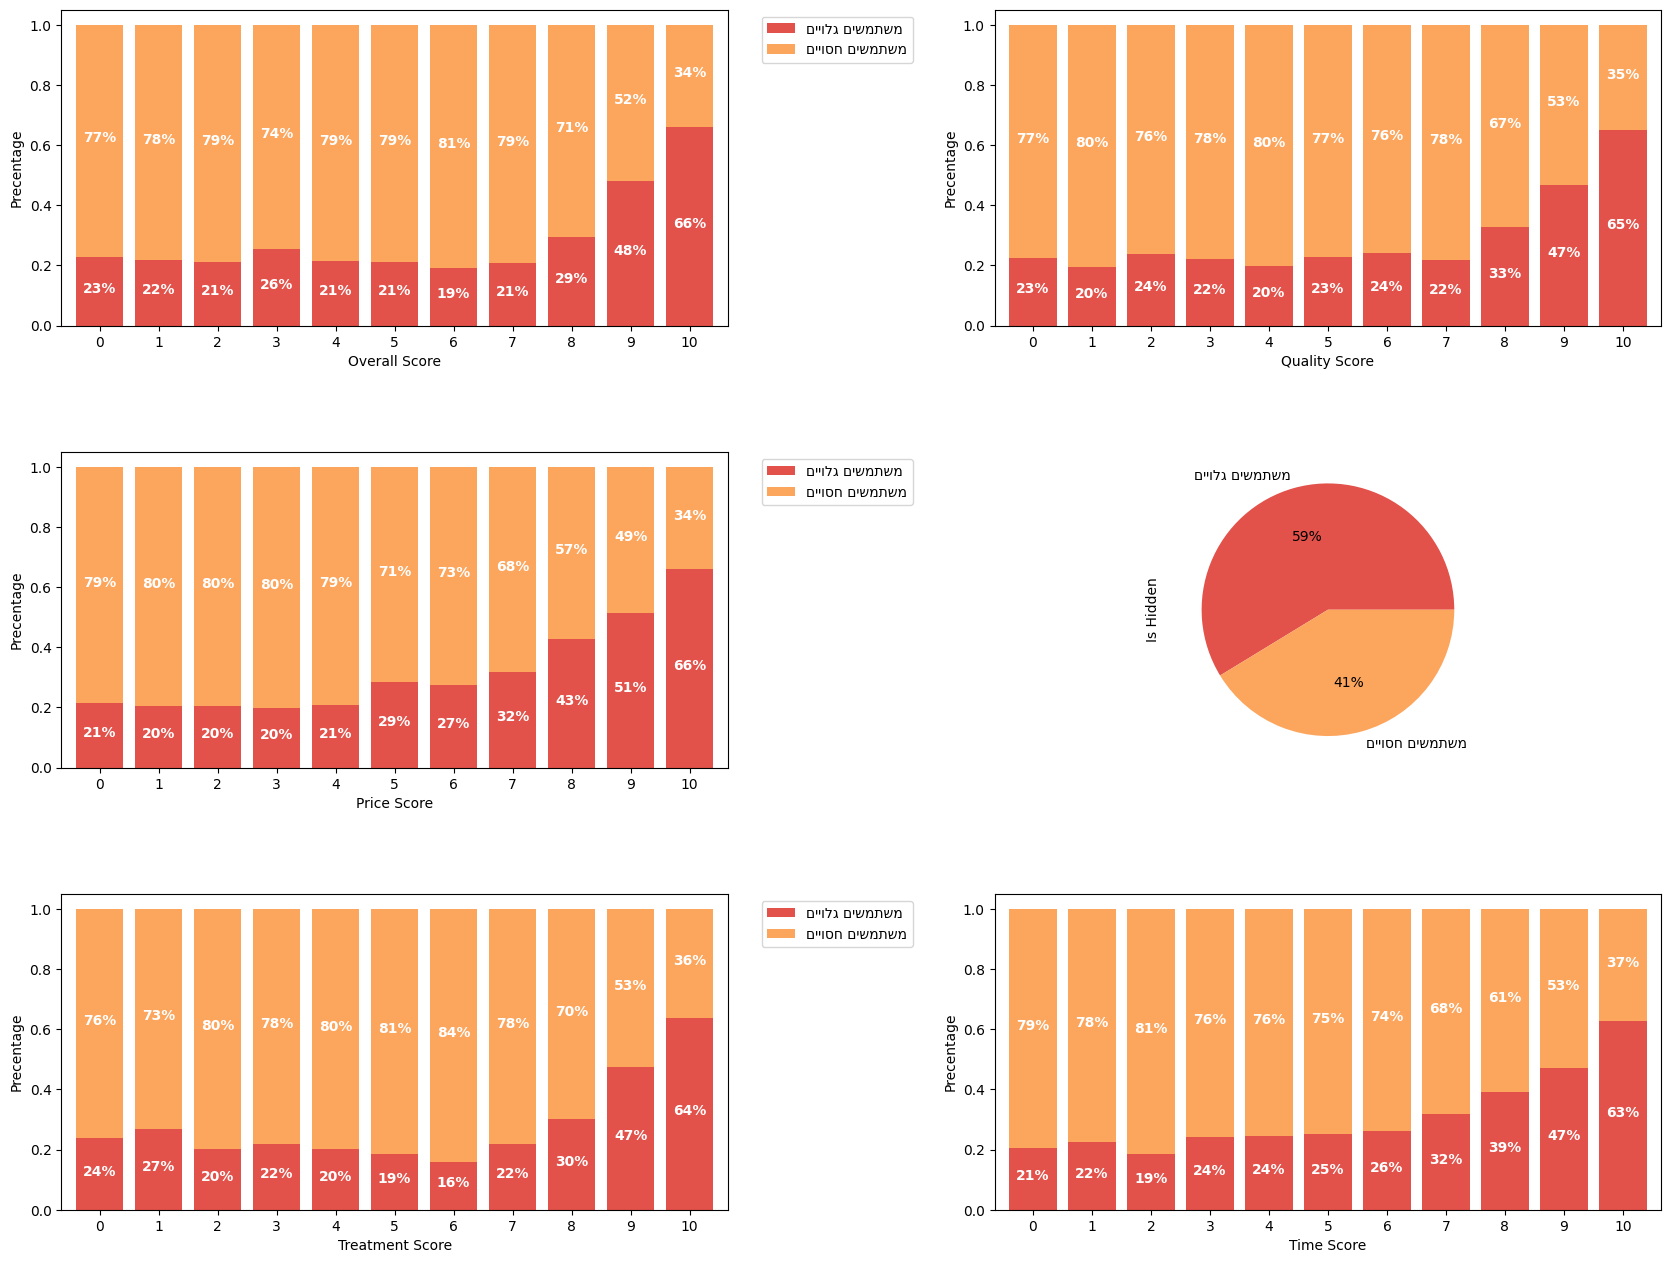

In [26]:
# Check differences between 'משתמשים גלויים' and 'משתמשים חסויים' based on the review's scores (Overall, Quality, Price, Time & Treatment)

filenames = Get_All_CSV_Names()
df_main = pd.DataFrame()

for csv in filenames:
    df_temp = pd.read_csv(f"data/{csv}.csv", usecols=['Overall Score', 'Quality Score', 'Price Score', 'Time Score', 'Treatment Score', 'Is Hidden'])
    df_main = pd.concat([df_main, df_temp])

df_hidden = df_main.loc[df_main["Is Hidden"] == 1]
df_not_hidden = df_main.loc[df_main["Is Hidden"] == 0]

fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
row,index = 0, 0

score_labels = ['Overall Score', 'Quality Score', 'Price Score', 'Time Score', 'Treatment Score']

for score in score_labels:
    # Calculating and normalizing the average score for hidden and visible customers
    ct = pd.crosstab(df_main[score], df_main['Is Hidden'], rownames=[score], colnames=['Is Hidden'])
    result = ct.apply(lambda x: x / x.sum(), axis=1)

    # Visualize In Graph
    if index == 0:
        plot = result.plot(ax=axes[row,index], kind='bar', stacked=True, width=0.8, figsize=(20, 15))
        plot.legend(['משתמשים גלויים'[::-1], 'משתמשים חסויים'[::-1]], loc='best')
        sns.move_legend(plot, "upper left", bbox_to_anchor=(1.04, 1))
    else:
        plot = result.plot(ax=axes[row,index], kind='bar', stacked=True, width=0.8, figsize=(20, 15), legend=False)

    plot.set_xlabel(score)
    plot.set_ylabel('Precentage')

    # Adding Percentage to the each bar, we used web for help
    for container in plot.containers:
        labels = [f'{h:.0%}' for h in container.datavalues]
        labels = plot.bar_label(container, labels=labels, label_type='center', fontsize=10, padding=2)
        for label in labels:
            label.set_color('white')
            label.set_weight('bold')
    
    plot.tick_params(axis='x', rotation=0)

    if index == 1:
        row += 1
        index = 0
    else:
        index+=1

# Pie chart to show the division between hidden and visible customer names
df_piechart = pd.DataFrame(df_main["Is Hidden"].value_counts())
df_piechart = df_piechart.rename(index={0:'משתמשים גלויים'[::-1], 1: 'משתמשים חסויים'[::-1]})

# Clear a better spot in the subplot for the pie chart 
temp = axes[1, 1].get_position()
axes[1, 1].set_position(axes[2, 1].get_position())
axes[2, 1].set_position(temp)

sns.set_palette('Spectral') # setting theme

df_piechart.plot(ax=axes[2,1], kind='pie', figsize=(20, 15), legend=False, autopct='%1.f%%', subplots=True)

In [24]:
# Credit: https://vincent.readthedocs.io/_/downloads/en/latest/pdf/
# Converting our data to a JSON in a format that folium can understand and visualize properly 

def Dataframe_To_Json(df:pd.DataFrame, x_axis, y_axis, title):
    vis = Visualization(width=500, height=300)
    vis.padding = {'top': 10, 'left': 50, 'bottom': 50, 'right': 100}

    vis.data.append(Data.from_pandas(df, columns=[y_axis], key_on=x_axis, name='table'))

    vis.scales.append(Scale(name='x', type='ordinal', range='width',
                            domain=DataRef(data='table', field="data.idx")))
    vis.scales.append(Scale(name='y', range='height', nice=True,
                            domain=DataRef(data='table', field="data.val")))

    vis.axes.extend([Axis(type='x', scale='x'), Axis(type='y', scale='y')])

    enter_props = PropertySet(x=ValueRef(scale='x', field="data.idx"),
                            y=ValueRef(scale='y', field="data.val"))
    update_props = PropertySet(stroke=ValueRef(value='orange'), stroke_width=ValueRef(value=2))
    mark = Mark(type='line', from_=MarkRef(data='table'),
                properties=MarkProperties(enter=enter_props, update=update_props))

    vis.marks.append(mark)
    vis.axis_titles(x=title, y='')

    vis_json = vis.to_json()
    return vis_json

In [28]:
# Credit: https://python-visualization.github.io/folium/*
# Visualize on a map our top-10 most reviewed cities and showing a graph representing the growth over the years with a popup
# Using Folium library and making an API call to "OpenStreetMap" to retrieve the coordinates of the cities

map = folium.Map(location=[31.786060, 35.200779], zoom_start=9)

# Loading all CSV into one DataFrame
filenames = Get_All_CSV_Names()
df = pd.DataFrame()
for csv in filenames:
    df_temp = pd.read_csv(f"data/{csv}.csv")
    df = pd.concat([df, df_temp])

# Creating new DataFrame: Calculating how many reviews are in each city
df['Location'] = df['Location'].astype(str)
places = df['Location'].value_counts().to_dict()

places_dict = []
for location, total_reviews in places.items():
    places_dict.append({'name': location, 'total_reviews': total_reviews})

places_dict= sorted(places_dict, key=lambda x: x['total_reviews'], reverse=True)

# Preparing the data and visualize it with Folium (with the popup chart)
for place in places_dict[:10]:
    url = f'https://nominatim.openstreetmap.org/search?q={place["name"]}+Israel&format=json'
    response = requests.get(url).json()
    if response:
        lat = response[0]['lat']
        lon = response[0]['lon']
        
        df_place = df[df['Location'] == place['name']]
        review_counts = pd.DataFrame(df_place['Year'].value_counts().sort_index()).rename(columns={'Year': 'Reviews Count'}).rename_axis('Year').reset_index()
        review_counts['Year'] = review_counts['Year'].astype(str)

        title = f'{place["name"]} - קצב גידול מספר ביקורות לאורך השנים'
        line_json = Dataframe_To_Json(review_counts, 'Year', 'Reviews Count', title)

        popup = folium.Popup(max_width=550)
        
        folium.Vega(line_json, height=350, width=550).add_to(popup)
        folium.Marker([lat, lon], popup=popup).add_to(map)

map